In [1]:
import os
import json
import re
import scipy.io as spio
import numpy as np
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
# %matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import skimage.color
from json_tricks.np import dump, dumps, load, loads
from mat2py import loadmat
from skimage import color
import cPickle as pkl

In [13]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [4]:
source = '/nas/volume1/2photon/projects'
experiment = 'gratings_phaseMod' #'retino_bar' #'gratings_phaseMod'
session = '20171009_CE059' #'20170902_CE054' #'20170825_CE055'
acquisition = 'FOV1_zoom3x' #'FOV1_zoom3x_run2' #'FOV1_planar'
functional_dir = 'functional'
acquisition_dir = os.path.join(source, experiment, session, acquisition)

analysis_id = 'analysis03'

In [5]:
acquisition_dir = os.path.join(source, experiment, session, acquisition)
figdir = os.path.join(acquisition_dir, 'figures', analysis_id)
if not os.path.exists(figdir):
    os.makedirs(figdir)
print "Saving figures to dir:", figdir

# Load reference info:
ref_json = 'reference_%s.json' % functional_dir 
with open(os.path.join(acquisition_dir, ref_json), 'r') as fr:
    ref = json.load(fr)

# Load SI meta data:
si_basepath = ref['raw_simeta_path'][0:-4]
simeta_json_path = '%s.json' % si_basepath
with open(simeta_json_path, 'r') as fs:
    simeta = json.load(fs)


Saving figures to dir: /nas/volume1/2photon/projects/gratings_phaseMod/20171009_CE059/FOV1_zoom3x/figures/analysis03


In [15]:
# Get stim params:
custom_mw = False
stim_on_sec = 2.0
iti_pre = 1.0
curr_slice_idx = 0
if custom_mw is False:
    currfile='File001'
    # stim_on_sec = 2.
    # iti = 1. #4.
    nframes = int(simeta[currfile]['SI']['hFastZ']['numVolumes'])
    framerate = float(simeta[currfile]['SI']['hRoiManager']['scanFrameRate'])
    volumerate = float(simeta[currfile]['SI']['hRoiManager']['scanVolumeRate'])
    frames_tsecs = np.arange(0, nframes)*(1/volumerate)

    nframes_on = stim_on_sec * volumerate
    #nframes_off = vols_per_trial - nframes_on
    nframes_iti_pre = round(iti_pre * volumerate) 
    print nframes_on
    print nframes_iti_pre

89.4054
45.0


In [16]:
# Get ROIPARAMS:
roi_dir = os.path.join(ref['roi_dir'], ref['roi_id'][analysis_id]) #, 'ROIs')
roiparams = loadmat(os.path.join(roi_dir, 'roiparams.mat'))
if 'roiparams' in roiparams.keys():
    roiparams = roiparams['roiparams']
maskpaths = roiparams['maskpaths']
print maskpaths
if not isinstance(maskpaths, list):
    maskpaths = [maskpaths] #[str(i) for i in maskpaths]


# Check slices to see if maskpaths exist for all slices, or just a subset:
if 'sourceslices' in roiparams.keys():
    slices = roiparams['sourceslices']
else:
    slices = np.arange(1, len(maskpaths)+1) #range(len(maskpaths))
print "Found masks for slices:", slices
if isinstance(slices, int):
    slices = [slices]
if not isinstance(slices, list): # i.e., only 1 slice
    slices = [int(i) for i in slices]


/nas/volume1/2photon/projects/gratings_phaseMod/20171009_CE059/FOV1_zoom3x/ROIs/manual2D_poly/masks/20171009_CE059_FOV1_zoom3x_Slice01_Channel01_masks.mat
Found masks for slices: 1


In [17]:
# Load masks:
#print maskpaths
masks = dict(("Slice%02d" % int(slice_idx), dict()) for slice_idx in slices)
for sidx,maskpath in zip(sorted(slices), sorted(maskpaths, key=natural_keys)):
    slice_name = "Slice%02d" % int(sidx) #+1)
    print "Loading masks: %s..." % slice_name 
    tmpmasks = loadmat(maskpath)
    if 'masks' in tmpmasks.keys():
        tmpmasks = tmpmasks['masks']
    masks[slice_name]['nrois'] =  tmpmasks.shape[2]
    masks[slice_name]['masks'] = tmpmasks

# Get specified slice masks:
slice_names = sorted(masks.keys(), key=natural_keys)
print "SLICE NAMES:", slice_names
curr_slice_name = slice_names[curr_slice_idx]
currmasks = masks[curr_slice_name]['masks']
print currmasks.shape

nrois = masks[curr_slice_name]['nrois']
print "NROIS:", nrois

Loading masks: Slice01...
SLICE NAMES: ['Slice01']
(512, 512, 17)
NROIS: 17


In [18]:
# Get FILE ("tiff") list
#avg_dir = options.avg_dir
avg_dir = ref['average_source'][analysis_id]
average_source = 'Averaged_Slices_%s' % avg_dir
signal_channel = ref['signal_channel'][analysis_id] #int(options.selected_channel)
average_slice_dir = os.path.join(acquisition_dir, functional_dir, 'DATA', average_source, "Channel{:02d}".format(signal_channel))
file_names = [f for f in os.listdir(average_slice_dir) if '_vis' not in f]
print "File names:", file_names
nfiles = len(file_names)

# Get AVERAGE slices (for current file):
curr_file_idx = 1
curr_file_name = file_names[curr_file_idx]
#curr_file_name = file_names[ref['refidx']]
curr_slice_dir = os.path.join(average_slice_dir, curr_file_name)
slice_fns = sorted([f for f in os.listdir(curr_slice_dir) if f.endswith('.tif')], key=natural_keys)

# Get average slice image for current-file, current-slice:
curr_slice_fn = slice_fns[curr_slice_idx]
avg_tiff_path = os.path.join(curr_slice_dir, curr_slice_fn)
with tf.TiffFile(avg_tiff_path) as tif:
    avgimg = tif.asarray()


File names: [u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010']


In [19]:
# Get PARADIGM INFO:
path_to_functional = os.path.join(acquisition_dir, functional_dir)
paradigm_dir = 'paradigm_files'
path_to_paradigm_files = os.path.join(path_to_functional, paradigm_dir)
#path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', roi_method, 'Parsed')
path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', ref['trace_id'][analysis_id], 'Parsed')

# Load stim trace structs:
print "Loading parsed traces..."
currchannel = "Channel%02d" % int(signal_channel)
stimtrace_fns = os.listdir(path_to_trace_structs)
stimtrace_fns = sorted([f for f in stimtrace_fns if 'stimtraces' in f and currchannel in f and f.endswith('.pkl')], key=natural_keys)
if len(stimtrace_fns)==0:
    print "No stim traces found for Channel %i" % int(selected_channel)
stimtrace_fn = stimtrace_fns[curr_slice_idx]
with open(os.path.join(path_to_trace_structs, stimtrace_fn), 'rb') as f:
    stimtraces = pkl.load(f)


stimlist = sorted(stimtraces.keys(), key=natural_keys)
nstimuli = len(stimlist)

Loading parsed traces...


In [21]:
color_by_roi = True
cmaptype = 'rainbow'

colormap = plt.get_cmap(cmaptype)

if color_by_roi:
    colorvals = colormap(np.linspace(0, 1, nrois)) #get_spaced_colors(nrois)
else:
    colorvals = colormap(np.linspace(0, 1, nstimuli)) #get_spaced_colors(nstimuli)

colorvals255 = [c[0:-1]*255 for c in colorvals]

In [70]:
roi = 10
spacing = 400

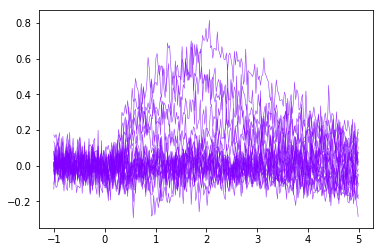

In [89]:
for stimnum,stim in enumerate(stimlist[5]):
    #dfs = traces[curr_roi][stim] #[:, roi, :]
    #raw = stimtraces[stim]['traces'][:, :, roi]
    ntrialstmp = len(stimtraces[stim]['traces'])
    #nframestmp = min([stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))])
    nframestmp = [stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))]
    diffs = np.diff(nframestmp)
    if sum(diffs)>0:
        print "Incorrect frame nums per trial:", stimnum, stim
        print nframestmp
    else:
        nframestmp = nframestmp[0]

    raw = np.empty((ntrialstmp, nframestmp))
    for trialnum in range(ntrialstmp):
        raw[trialnum, :] = stimtraces[stim]['traces'][trialnum][0:nframestmp, roi].T

    for trial in range(ntrials):
        if custom_mw is True:
            frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
            frame_off = stimtraces[stim]['frames_stim_on'][trial][-1]
            frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)

        else:
            frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
            frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)

        xvals[trial, :] = (stimtraces[stim]['frames'][trial] - frame_on) + stimnum*spacing
        baseline = np.mean(raw[trial, 0:frame_on_idx])

        df = (raw[trial,:] - baseline) / baseline
                #print stim, trial
        curr_dfs[trial,:] = df

        plt.plot(xvals[trial,:]/framerate, curr_dfs[trial,:], color=colorvals[stimnum], alpha=0.5, linewidth=trial_width)
plt.show()

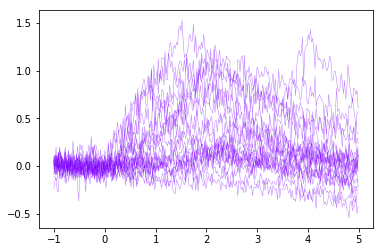

In [87]:
plt.show()

In [33]:
#stimtraces[stim]['traces'][trialnum].shape
# nframestmp = [stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))]
# print nframestmp

[269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269]


In [46]:
#xvals = np.arange(0, raw.shape[1])# + stimnum*spacing
#xvals = np.tile(np.arange(0, raw.shape[1]), (raw.shape[0], 1))
ntrials = raw.shape[0]
nframes_in_trial = raw.shape[1]
# print "ntrials: %i, nframes in trial: %i" % (ntrials, nframes_in_trial)

curr_dfs = np.empty((ntrials, nframes_in_trial))
xvals = np.empty((ntrials, nframes_in_trial))

In [47]:
for trial in range(ntrials):
    if custom_mw is True:
        frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
        frame_off = stimtraces[stim]['frames_stim_on'][trial][-1]
        frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)

    else:
        frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
        frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)
        
    xvals[trial, :] = stimtraces[stim]['frames'][trial] - frame_on
    baseline = np.mean(raw[trial, 0:frame_on_idx])

    df = (raw[trial,:] - baseline) / baseline
            #print stim, trial
    curr_dfs[trial,:] = df
    
    plt.plot(xvals[t,:]/framerate, curr_dfs[t,:], color=colorvals[roi], alpha=trial_alpha, linewidth=trial_width)


In [51]:
xvals[0]/framerate


array([-1.0066506 , -0.98428059, -0.96191058, -0.93954056, -0.91717055,
       -0.89480054, -0.87243052, -0.85006051, -0.8276905 , -0.80532048,
       -0.78295047, -0.76058046, -0.73821044, -0.71584043, -0.69347042,
       -0.6711004 , -0.64873039, -0.62636038, -0.60399036, -0.58162035,
       -0.55925034, -0.53688032, -0.51451031, -0.4921403 , -0.46977028,
       -0.44740027, -0.42503026, -0.40266024, -0.38029023, -0.35792022,
       -0.3355502 , -0.31318019, -0.29081017, -0.26844016, -0.24607015,
       -0.22370013, -0.20133012, -0.17896011, -0.15659009, -0.13422008,
       -0.11185007, -0.08948005, -0.06711004, -0.04474003, -0.02237001,
        0.        ,  0.02237001,  0.04474003,  0.06711004,  0.08948005,
        0.11185007,  0.13422008,  0.15659009,  0.17896011,  0.20133012,
        0.22370013,  0.24607015,  0.26844016,  0.29081017,  0.31318019,
        0.3355502 ,  0.35792022,  0.38029023,  0.40266024,  0.42503026,
        0.44740027,  0.46977028,  0.4921403 ,  0.51451031,  0.53

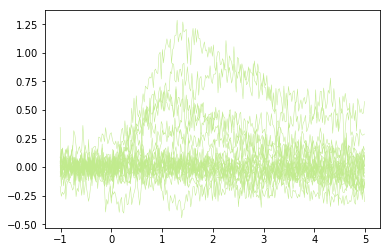

In [52]:
trial_alpha = 1
trial_width = 0.5
for t in range(ntrials):
    plt.plot(xvals[t,:]/framerate, curr_dfs[t,:], color=colorvals[roi], alpha=trial_alpha, linewidth=trial_width)
plt.show()

In [28]:
stimtraces[stim]['frames_stim_on'][trial]

[6103, 6192.4054]

In [29]:
stimtraces[stim]['frames'][trial]

array([6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068,
       6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079,
       6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090,
       6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101,
       6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112,
       6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123,
       6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134,
       6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145,
       6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156,
       6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167,
       6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178,
       6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189,
       6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200,
       6201, 6202, 6203, 6204, 6205, 6206, 6207, 62

In [ ]:
baseline = np.mean(raw[trial, 0:frame_on_idx])

df = (raw[trial,:] - baseline) / baseline
        #print stim, trial
curr_dfs[trial,:] = df
        if color_by_roi:
            plt.plot(xvals, df, color=colorvals[roi], alpha=trial_alpha, linewidth=trial_width)
        else:
            plt.plot(xvals, df, color=colorvals[stimnum], alpha=trial_alpha, linewidth=trial_width)
